In [1]:
from fastai.vision.all import *
import librosa as librosa

# Loading Specs

In [2]:
def chunk_to_spec(chunk, SPEC_HEIGHT=64,SPEC_WIDTH=256, rate=32000, FMIN=200, FMAX=12500):
    mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                              sr=32000, 
                                              n_fft=1024, 
                                              hop_length=int(32000 * 5 / (SPEC_WIDTH - 1)), 
                                              n_mels=SPEC_HEIGHT, 
                                              fmin=FMIN, 
                                              fmax=FMAX)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [3]:
df = pd.read_csv('../input/peak-identification/info_df.csv')
print(df.shape)
df.head(3)

(62874, 4)


,fn,len,label,peaks
0,/kaggle/input/birdclef-2021/train_short_audio/caltow/XC125795.ogg,934174,caltow,1.120#26.76#4.609#16.29#21.31#25.78#1.920#15.34#28.12#7.122#24.64#8.274#17.09#11.31#9.554#18.42#13.62#20.45#19.52#2.832
1,/kaggle/input/birdclef-2021/train_short_audio/caltow/XC297483.ogg,822161,caltow,16.82#8.884#2.000#24.76#17.70#20.48#18.96#13.43#3.601#15.78#1.072#25.56#23.94#10.10#21.89#6.195#7.811#22.76#11.57#0.272
2,/kaggle/input/birdclef-2021/train_short_audio/caltow/XC482520.ogg,1855904,caltow,18.06#6.193#16.89#36.45#32.91#5.329#30.16#35.51#14.46#16.08#31.47#26.87#42.32#8.465#15.26#37.25#19.57#54.82#41.19#22.30


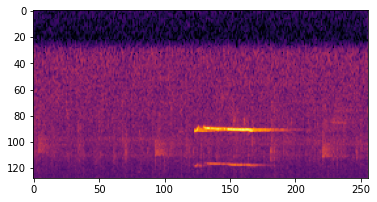

In [4]:
fn, l, y, peaks = df.sample().values[0]
start_time = min(l/32000 - 5, max(float(peaks.split('#')[0])-2.5, 2.5))
y, sr = librosa.load(fn, sr=32000, offset=start_time, duration=5)
plt.imshow(chunk_to_spec(y, SPEC_HEIGHT=128), cmap='inferno')

# DataLoaders

train and val size 50299 12575
torch.Size([16, 3, 112, 224])


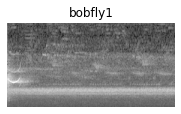

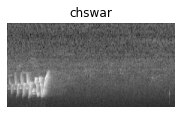

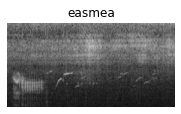

In [5]:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

class ClipTransform(ItemTransform):

    def __init__(self, df):
        self.df=df
        self.vocab,self.o2i = uniqueify(df['label'], sort=True, bidir=True)
        
    def encodes(self, i, from_np=False):
        f, l, label, peaks = df.iloc[i].values
        clip_num = random.choice([0, 0, 0, 1, 1, 2, 3, 4, 5, 6]) # More prob chose big peak
        start_time = min(l/32000 - 5, max(float(peaks.split('#')[clip_num])-2.5, 2.5))
        y, sr = librosa.load(f, sr=32000, offset=start_time, duration=5)
        spec = chunk_to_spec(y,SPEC_HEIGHT=112,SPEC_WIDTH=224)
        spec -= np.min(spec) 
        spec /= 80 # np.max(spec) # Normalize
        spec =  torch.unsqueeze(tensor(spec), 0)
        spec = torch.cat([spec, spec, spec]) # Stack three channels to simulate RGB if using a pretrained model
        return spec, self.o2i[label]
    
    def decodes(self, x):
        return TitledImage(x[0],self.vocab[x[1]])


df_small = df
clip_tfm = ClipTransform(df)
train =  df_small.sample(frac=0.8)
train_idx, valid_idx = list(train.index), df_small[~df_small.index.isin(train.index)].index
print('train and val size', len(train_idx), len(valid_idx))
train_tl= TfmdLists(train_idx, clip_tfm)
valid_tl= TfmdLists(valid_idx, clip_tfm)
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=16)
dls = dls.cuda()
xb, yb = dls.one_batch()
print(xb.shape)
dls.show_batch(max_n=3)

In [6]:
learn = cnn_learner(dls, models.resnet18, loss_func=FocalLossFlat(), metrics=[accuracy], cbs=[ShowGraphCallback(), CSVLogger()])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
print('Model created and ready for training')

Model created and ready for training


epoch,train_loss,valid_loss,accuracy,time
0,4.017033,3.483125,0.251849,2:23:33
1,2.846966,2.380223,0.458926,2:22:47
2,2.371668,2.065243,0.531292,2:20:55


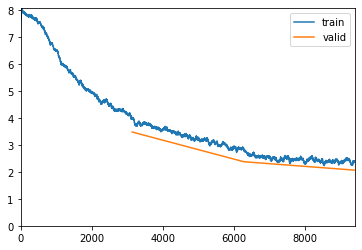

In [8]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-3))

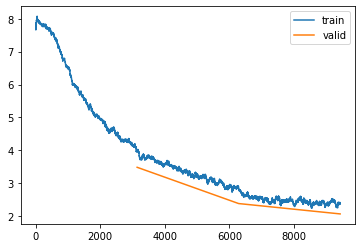

In [9]:
learn.recorder.plot_loss()
plt.savefig('loss_plot.png')

In [10]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [11]:
learn.remove_cb(CSVLogger) # Not pickleable
learn.export('baseline_3e.pkl')

In [12]:
# !pip install -q wandb
# import wandb
# wandb.init()
# from fastai.callback.wandb import *
# # And add cbs=WandbCallback() to log